
# Homework 1 DSCI 552, Instructor: Mohammad Reza Rajati

### Vertebral Column Data Set  
  
This Biomedical data set was built by Dr. Henrique da Mota during a medical residence
period in Lyon, France. Each patient in the data set is represented in the data set
by six biomechanical attributes derived from the shape and orientation of the pelvis
and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle,
sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is
used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and
Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0
and AB=1.

In [1]:
import pandas as pd
from scipy.io import  arff
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import DistanceMetric


1(a). Download the Vertebral Column Data Set from:
https://archive.ics.uci.
edu/ml/datasets/Vertebral+Column
.

In [2]:
arff = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
df = pd.DataFrame(arff[0])

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'


In [4]:
df = df.assign(class_binary = (df["class"].str.decode('utf-8') == 'Abnormal').astype(int))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
 7   class_binary              310 non-null    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 19.5+ KB


#### Pre-Processing and Exploratory data analysis:  


1(b)i.  Make scatterplots of the independent variables in the dataset. Use color to
show Classes 0 and 1.  
 

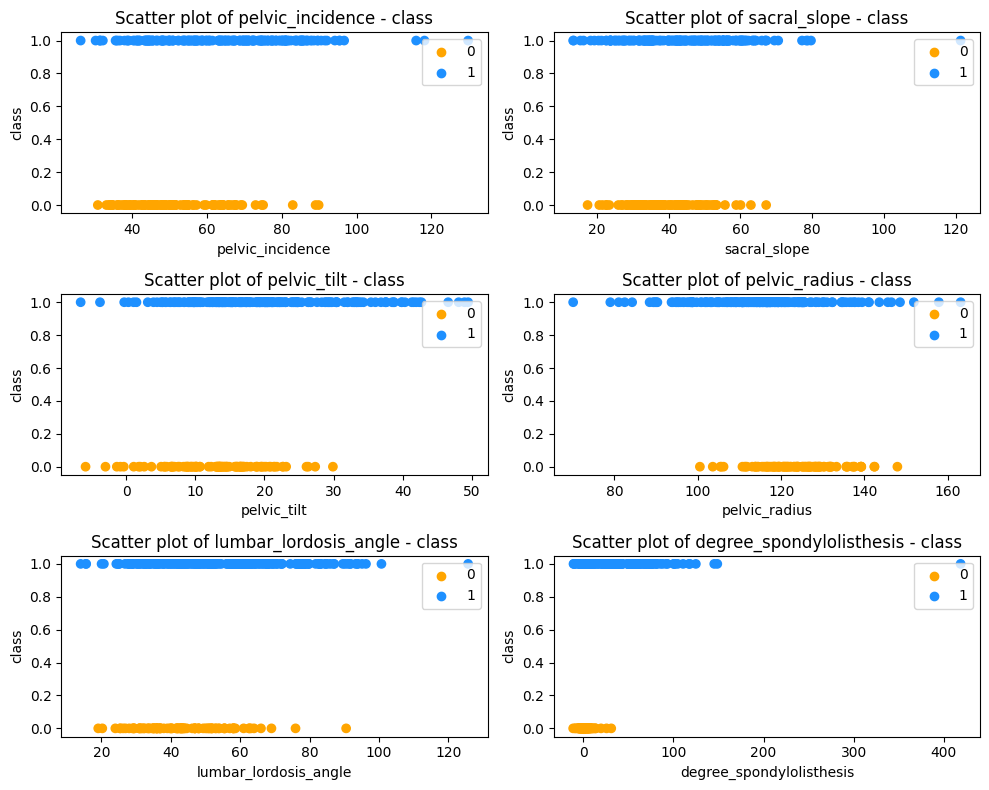

In [6]:
figure, axis = plt.subplots(3, 2, figsize=(10, 8))
colors = df["class_binary"].map({0: "orange", 1: "dodgerblue"})

cols = df.columns[:-2]
label = df.columns[-1]

for i in range(6):
    x, y = i % 3, i // 3
    splot = axis[x, y].scatter(df[cols[i]], df[label], c = colors)
    axis[x, y].scatter([], [], c='orange', label='0')  
    axis[x, y].scatter([], [], c='dodgerblue', label='1') 
    axis[x, y].legend(loc='upper right')
    axis[x, y].set_ylabel("class")
    axis[x, y].set_xlabel(cols[i])
    axis[x, y].set_title(f"Scatter plot of {cols[i]} - class")
    
plt.tight_layout()
plt.show()

1(b)ii.  Make boxplots for each of the independent variables. Use color to show
Classes 0 and 1 (see ISLR p. 129). 

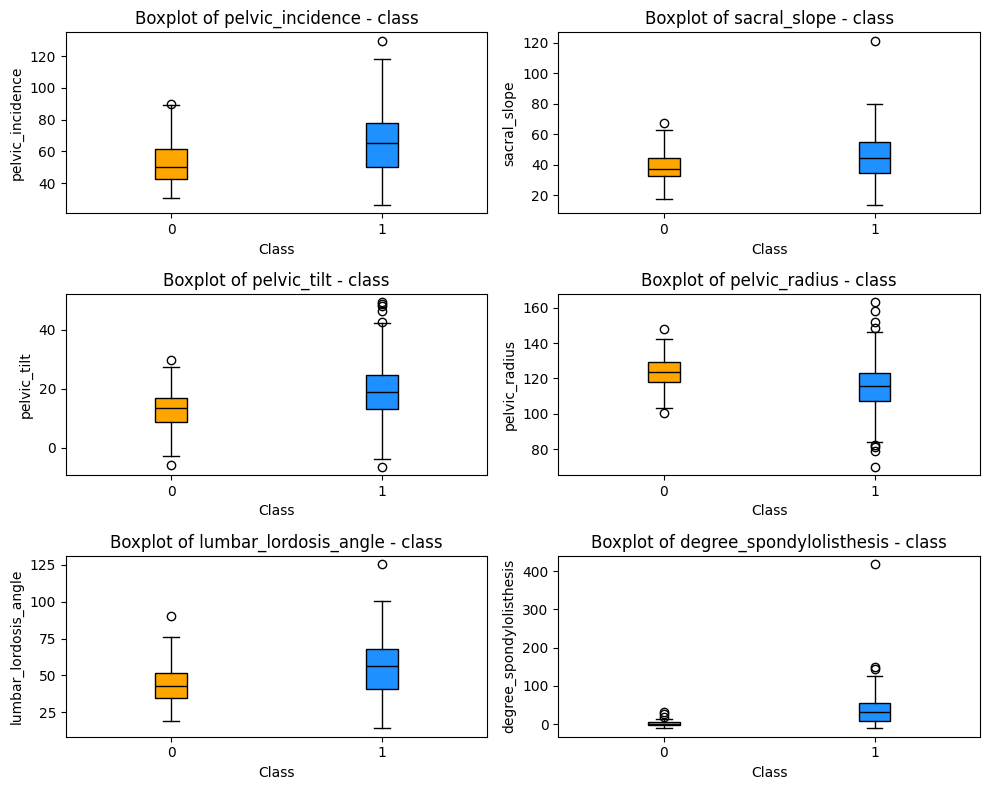

In [7]:

figure2, axis2 = plt.subplots(3, 2, figsize=(10, 8))
cols = df.columns[:-2]
label = df.columns[-1]
colors = ["orange", "dodgerblue"]

for i in range(6):
    x, y = i % 3, i // 3
    labels = [0, 1]
    bplot = axis2[x, y].boxplot([df[df[label] == 0][cols[i]], df[df[label] == 1][cols[i]]], patch_artist=True, medianprops = {"color": "black", "linewidth": 1}, tick_labels = labels)
    axis2[x, y].set_xlabel("Class")
    axis2[x, y].set_ylabel(cols[i])
    axis2[x, y].set_title(f"Boxplot of {cols[i]} - class")

    for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

plt.tight_layout()
plt.show()



1(b)iii.  Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the
training set and the rest of the data as the test set.

In [8]:
X_train = np.concatenate((df[df["class_binary"] == 0].iloc[:70, 0:-2].to_numpy(), df[df["class_binary"] == 1].iloc[:140, 0:-2].to_numpy()), axis = 0)
y_train = np.concatenate((df[df["class_binary"] == 0].iloc[:70, -1].to_numpy(), df[df["class_binary"] == 1].iloc[:140, -1].to_numpy()), axis = 0)

X_test = np.concatenate((df[df["class_binary"] == 0].iloc[70:, 0:-2].to_numpy(), df[df["class_binary"] == 1].iloc[140:, 0:-2].to_numpy()), axis = 0)
y_test = np.concatenate((df[df["class_binary"] == 0].iloc[70:, -1].to_numpy(), df[df["class_binary"] == 1].iloc[140:, -1].to_numpy()), axis = 0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 



(210, 6) (210,) (100, 6) (100,)


In [9]:
# scaler = StandardScaler()
# scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [10]:
lowest_training_error = {
    "question": None,
    "metric": None,
    "K": None,
    "training error": 1,
    "test error": None
}

#### Classification using KNN on Vertebral Column Data Set

1(c)i. Write code for k-nearest neighbors with Euclidean metric (or use a software
package)

In [11]:
k_lst = []
train_err_lst = []
test_err_lst = []

for k in range(208, 0, -3):

    KNN_classifier = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    KNN_classifier.fit(X_train, y_train)
    y_pred = KNN_classifier.predict(X_test)

    train_err = 1 - KNN_classifier.score(X_train, y_train)
    test_err = 1 - KNN_classifier.score(X_test, y_test)

    k_lst.append(k)
    train_err_lst.append(train_err)
    test_err_lst.append(test_err)

    if lowest_training_error["training error"] >= train_err:
        lowest_training_error = {
            "question": "1(c)i",
            "metric": "euclidean",
            "K": k,
            "training error": train_err,
            "test error": test_err
        }



1(c)ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈ { 208 , 205 , . . . , 7 , 4 , 1 , } (in reverse order). You are welcome to use smaller increments of k . Which k ∗ is the most suitable k among those values? Cal- culate the confusion matrix, true positive rate, true negative rate, precision, and F 1 -score when k = k∗ .


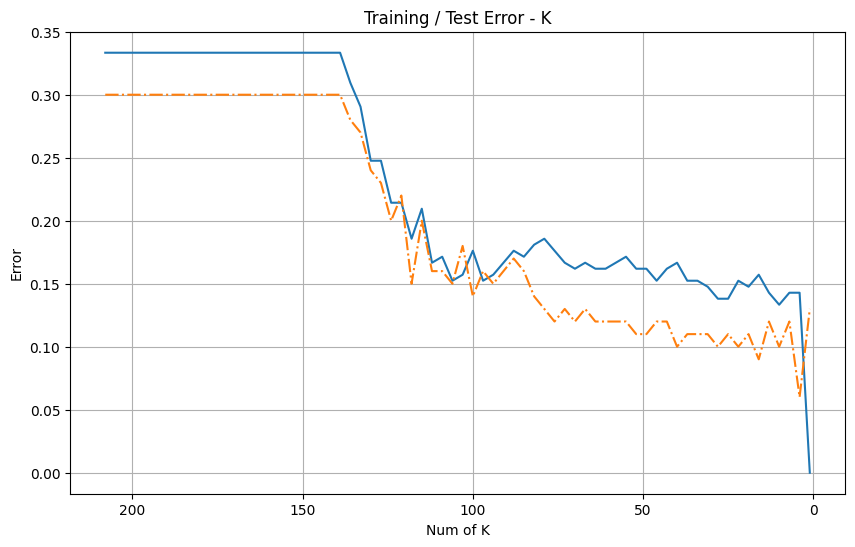

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(k_lst, train_err_lst)
plt.plot(k_lst, test_err_lst, '-.')

plt.xlabel("Num of K")
plt.ylabel("Error")
plt.title('Training / Test Error - K')

plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [13]:
min_K = k_lst[test_err_lst.index(min(test_err_lst))]
print(f"Minimum K: {min_K}")

KNN_classifier = KNeighborsClassifier(n_neighbors=min_K, metric="euclidean")
KNN_classifier.fit(X_train, y_train)
y_pred = KNN_classifier.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(CM)

tn, fp, fn, tp = CM.ravel()
print(f"\ntn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}\n")

# true positive rate = tp/(tp + fn)
recall = tp/(tp + fn)
print(f"true positive rate: {recall}")

# true negative rate = tn/(tn + fp)
print(f"true negative rate: {tn/(tn +fp)}")

# precision = tp/(tp + fp)
precision = tp/(tp + fp)
print(f"precision: {precision}")

# f1-score = 2 * precision * recall / (precision + recall), recall = tp/(tp + fn)
print(f"f1-score: {2 * precision * recall/(precision + recall)}")


Minimum K: 4
Confusion Matrix:
[[25  5]
 [ 1 69]]

tn: 25, fp: 5, fn: 1, tp: 69

true positive rate: 0.9857142857142858
true negative rate: 0.8333333333333334
precision: 0.9324324324324325
f1-score: 0.9583333333333333


1(c)iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error rate , 3 which is obtained by some value of k , against the size of training set, when the size of training set is N ∈ { 10 , 20 , 30 , . . . , 210 } . 4 Note: for each N , select your training set by choosing the first b N/ 3 c rows of Class 0 and the first N − b N/ 3 c rows of Class 1 in the training set you created in 1(b)iii. Also, for each N , select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from { 1 , 6 , 11 , . . . , 196 } . This plot is called a Learning Curve


In [14]:
best_test_err_dict = {}

for N in range(10, 211, 10):
    sub_X = np.concatenate((X_train[np.where(y_train == 0)][0:round(N/3)], X_train[np.where(y_train == 1)][0: N-round(N/3)]), axis = 0)
    sub_y = np.concatenate((y_train[np.where(y_train == 0)][0:round(N/3)], y_train[np.where(y_train == 1)][0: N-round(N/3)]), axis = 0)
    best_test_err = 1

    for K in range(1, N+1, 5):
        KNN_classifier = KNeighborsClassifier(n_neighbors=K, metric="euclidean")
        KNN_classifier.fit(sub_X, sub_y)
        y_pred = KNN_classifier.predict(X_test)
        train_err = 1 - KNN_classifier.score(sub_X, sub_y)
        test_err = 1 - KNN_classifier.score(X_test, y_test)
        
        if test_err <= best_test_err:
            best_test_err = test_err
            best_test_err_dict.update(
                {
                    N:{
                        "best_K": K,
                        "best_test_err": best_test_err
                    }
                }
            )

        if lowest_training_error["training error"] >= train_err:
            lowest_training_error = {
                "question": "1(c)iii",
                "metric": "euclidean",
                "K": K,
                "N": N,
                "training error": train_err,
                "test error": test_err
            }


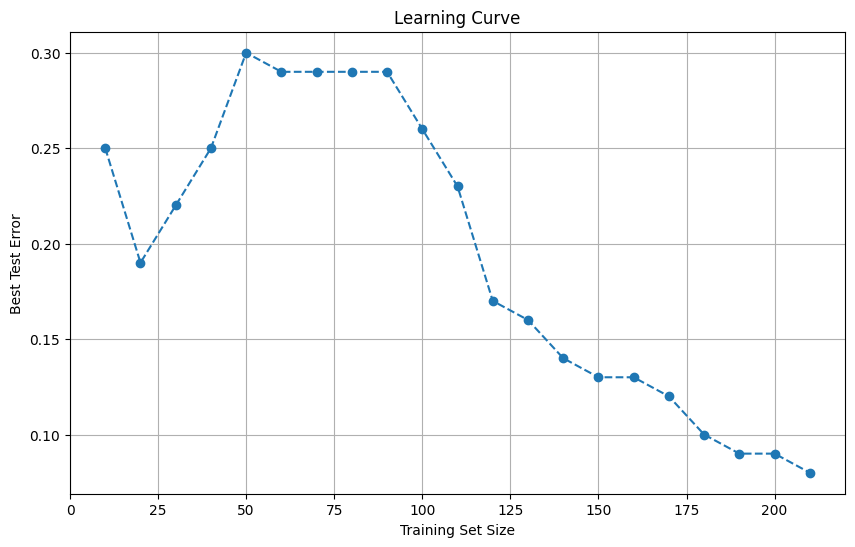

In [15]:
training_size_lst = [key for key in best_test_err_dict.keys()]
best_test_err_lst = [value.get("best_test_err") for value in best_test_err_dict.values()]

plt.figure(figsize=(10, 6))
plt.plot(training_size_lst, best_test_err_lst, marker='o', linestyle='--')
plt.xlabel("Training Set Size")
plt.ylabel("Best Test Error")
plt.title("Learning Curve")
plt.grid(True)
plt.show()

Replace the Euclidean metric with the following metrics 5 and test them. Summarize the test errors (i.e., when k = k ∗ ) in a table. Use all of your training data and select the best k when { 1 , 6 , 11 , . . . , 196 } 

1(d)iA. Minkowski Distance: which becomes Manhattan Distance with p= 1

In [16]:
distance_table_dict = {}

best_test_err = 1
for K in range(1, 197, 5):
    KNN_classifier = KNeighborsClassifier(n_neighbors=K, metric="minkowski", p=1)
    KNN_classifier.fit(X_train, y_train)
    y_pred = KNN_classifier.predict(X_test)
    train_err = 1 - KNN_classifier.score(X_train, y_train)
    test_err = 1 - KNN_classifier.score(X_test, y_test)

    if test_err <= best_test_err:
        best_test_err = test_err
        distance_table_dict.update(
            {
                "Manhattan": {
                    "p": 1,
                    "best_K": K,
                    "best_test_err": best_test_err
                }
            }

        )

    if lowest_training_error["training error"] >= train_err:
        lowest_training_error = {
            "question": "1(d)iA",
            "metric": "minkowski",
            "p": 1,
            "K": K,
            "N": N,
            "training error": train_err,
            "test error": test_err
        }

distance_table_dict

{'Manhattan': {'p': 1, 'best_K': 26, 'best_test_err': 0.10999999999999999}}

1(d)iB. with log 10 ( p ) ∈ { 0 . 1 , 0 . 2 , 0 . 3 , . . . , 1 } . In this case, use the k ∗ you found for the Manhattan distance in 1(d)iA. What is the best log 10 ( p )?

In [17]:
best_test_err = 1
for p in range(1, 11, 1):
    KNN_classifier = KNeighborsClassifier(n_neighbors=distance_table_dict["Manhattan"]["best_K"], metric="minkowski", p=10**(p/10))
    KNN_classifier.fit(X_train, y_train)
    y_pred = KNN_classifier.predict(X_test)
    train_err = 1 - KNN_classifier.score(X_train, y_train)
    test_err = 1 - KNN_classifier.score(X_test, y_test)

    if test_err <= best_test_err:
        best_test_err = test_err
        distance_table_dict.update(
            {
                "Minkowski": {
                    "p": 10**(p/10),
                    "best_K": distance_table_dict["Manhattan"]["best_K"],
                    "best_log(p)": p/10,
                    "best_test_err": best_test_err
                }
            }
        )

    if lowest_training_error["training error"] >= train_err:
        lowest_training_error = {
            "question": "1(d)iB",
            "metric": "minkowski",
            "p": 10**(p/10),
            "log(p)": p/10,
            "K": distance_table_dict["Manhattan"]["best_K"],
            "training error": train_err,
            "test error": test_err
        }

distance_table_dict

{'Manhattan': {'p': 1, 'best_K': 26, 'best_test_err': 0.10999999999999999},
 'Minkowski': {'p': 3.9810717055349722,
  'best_K': 26,
  'best_log(p)': 0.6,
  'best_test_err': 0.09999999999999998}}

1(d)iC. which becomes Chebyshev Distance with p → ∞

In [18]:
best_test_err = 1
for K in range(1, 197, 5):
    KNN_classifier = KNeighborsClassifier(n_neighbors=K, metric="minkowski", p=float("inf"))
    KNN_classifier.fit(X_train, y_train)
    y_pred = KNN_classifier.predict(X_test)
    train_err = 1 - KNN_classifier.score(X_train, y_train)
    test_err = 1 - KNN_classifier.score(X_test, y_test)

    if test_err <= best_test_err:
        best_test_err = test_err
        distance_table_dict.update(
            {
                "Chebyshev": {
                    "p": "inf",
                    "best_K": K,
                    "best_test_err": best_test_err
                }
            }

        )

    if lowest_training_error["training error"] >= train_err:
        lowest_training_error = {
            "question": "1(d)iC",
            "metric": "minkowski",
            "p": "inf",
            "K": K,
            "training error": train_err,
            "test error": test_err
        }
distance_table_dict

{'Manhattan': {'p': 1, 'best_K': 26, 'best_test_err': 0.10999999999999999},
 'Minkowski': {'p': 3.9810717055349722,
  'best_K': 26,
  'best_log(p)': 0.6,
  'best_test_err': 0.09999999999999998},
 'Chebyshev': {'p': 'inf', 'best_K': 16, 'best_test_err': 0.07999999999999996}}

1(d)ii. Mahalanobis Distance.

In [19]:
best_test_err = 1
cov = np.cov(X_train.T)

try:
    inv_cov = np.linalg.inv(cov)
except:
    inv_cov = np.linalg.pinv(cov)

mahalanobis_metric = DistanceMetric.get_metric('mahalanobis', V=inv_cov)

for K in range(1, 197, 5):
    KNN_classifier = KNeighborsClassifier(n_neighbors=K, metric=mahalanobis_metric)
    KNN_classifier.fit(X_train, y_train)
    y_pred = KNN_classifier.predict(X_test)
    train_err = 1 - KNN_classifier.score(X_train, y_train)
    test_err = 1 - KNN_classifier.score(X_test, y_test)

    if test_err <= best_test_err:
        best_test_err = test_err
        distance_table_dict.update(
            {
                "Mahalanobis": {
                    "best_K": K,
                    "best_test_err": best_test_err
                }
            }

        )

    if lowest_training_error["training error"] >= train_err:
        lowest_training_error = {
            "question": "1(d)ii",
            "metric": "mahalanobis",
            "K": K,
            "training error": train_err,
            "test error": test_err
        }
distance_table_dict

{'Manhattan': {'p': 1, 'best_K': 26, 'best_test_err': 0.10999999999999999},
 'Minkowski': {'p': 3.9810717055349722,
  'best_K': 26,
  'best_log(p)': 0.6,
  'best_test_err': 0.09999999999999998},
 'Chebyshev': {'p': 'inf', 'best_K': 16, 'best_test_err': 0.07999999999999996},
 'Mahalanobis': {'best_K': 16, 'best_test_err': 0.06999999999999995}}

In [20]:
pd.DataFrame(distance_table_dict)

,Manhattan,Minkowski,Chebyshev,Mahalanobis
p,1.00,3.981072,inf,NaN
best_K,26.00,26.000000,16,16.00
best_test_err,0.11,0.100000,0.08,0.07
best_log(p),NaN,0.600000,NaN,NaN


1(e). The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k ∈ { 1 , 6 , 11 , 16 , . . . , 196 } 

In [21]:
question_e_result = {}

def question_e(_k_range: list, _metric: str, _X_train: list, _y_train: list, _result_dict: dict, lowest_training_error: dict):
    best_test_err = 1

    for K in range(_k_range[0], _k_range[1], _k_range[2]):
        KNN_classifier = KNeighborsClassifier(n_neighbors=K, metric=_metric, weights = "distance")
        KNN_classifier.fit(_X_train, _y_train)
        y_pred = KNN_classifier.predict(X_test)
        train_err = 1 - KNN_classifier.score(_X_train, _y_train)
        test_err = 1 - KNN_classifier.score(X_test, y_test)
        
        if test_err <= best_test_err:
            best_test_err = test_err
            _result_dict.update(
                {
                    _metric:{
                        "best_K": K,
                        "best_test_err": best_test_err
                    }
                }
            )
            # print(f"K: {K}, train_err: {train_err}, test_err: {test_err}")

        if lowest_training_error["training error"] >= train_err:
            lowest_training_error = {
                "question": "1(e)",
                "metric": _metric,
                "K": K,
                "training error": train_err,
                "test error": test_err
            }
    return lowest_training_error

In [22]:
lowest_training_error = question_e([1, 197, 5], "euclidean", X_train, y_train, question_e_result, lowest_training_error)
lowest_training_error = question_e([1, 197, 5], "manhattan", X_train, y_train, question_e_result, lowest_training_error)
lowest_training_error = question_e([1, 197, 5], "chebyshev", X_train, y_train, question_e_result, lowest_training_error)

question_e_result

{'euclidean': {'best_K': 6, 'best_test_err': 0.09999999999999998},
 'manhattan': {'best_K': 26, 'best_test_err': 0.09999999999999998},
 'chebyshev': {'best_K': 61, 'best_test_err': 0.10999999999999999}}

1(f). What is the lowest training error rate you achieved in this homework?

In [23]:
print(f"Information of Lowest Training Error: \n{lowest_training_error}\n")
print(f"Lowest Training Error: {lowest_training_error['training error']}")

Information of Lowest Training Error: 
{'question': '1(e)', 'metric': 'chebyshev', 'K': 196, 'training error': 0.0, 'test error': 0.28}

Lowest Training Error: 0.0


References:

Mahalanobis:
The idea of trying inverse matrix except pseudo-inverse matrix is came from ChatGPT, and I combine this idea with following link to complete the task of Mahalanobis.  
https://www.kaggle.com/discussions/questions-and-answers/428879

